In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [2]:
#monitor execution time
import time as tm
t_start = tm.time()

In [3]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  468


['permutations/sim_id=224!total_ring_mass=9.999999999999985e-12!shear_viscosity=2.154434690031887e-14!bulk_viscosity=2.154434690031887e-14!radial_width=2.5e-05!timesteps_per_output=821!',
 'permutations/sim_id=86!total_ring_mass=3.162277660168375e-13!shear_viscosity=4.641588833612771e-13!bulk_viscosity=4.641588833612771e-13!radial_width=0.0001!timesteps_per_output=124!',
 'permutations/sim_id=432!total_ring_mass=1.0000000000000007e-09!shear_viscosity=2.154434690031887e-14!bulk_viscosity=2.154434690031887e-14!radial_width=2.5e-05!timesteps_per_output=30600!',
 'permutations/sim_id=244!total_ring_mass=9.999999999999985e-12!shear_viscosity=1.000000000000001e-12!bulk_viscosity=1.000000000000001e-12!radial_width=2.5e-05!timesteps_per_output=149!',
 'permutations/sim_id=321!total_ring_mass=9.999999999999996e-11!shear_viscosity=4.641588833612777e-15!bulk_viscosity=4.641588833612777e-15!radial_width=5e-05!timesteps_per_output=510!']

In [4]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [5]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('!total_ring_mass=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

,sim_id,path
0,0,permutations/sim_id=0!total_ring_mass=9.999999...
1,1,permutations/sim_id=1!total_ring_mass=9.999999...
2,2,permutations/sim_id=2!total_ring_mass=9.999999...
3,3,permutations/sim_id=3!total_ring_mass=9.999999...
4,4,permutations/sim_id=4!total_ring_mass=9.999999...


In [6]:
#nominal ringlet's properties
nominal_total_ring_mass = 1.0e-10
nominal_shear_viscosity = 1.0e-13
nominal_radial_width = 0.0001

In [7]:
#get outcome of every sim
df = paths_df
plot_q = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #check if sim completed
    d['outcome'] = 'unsure'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #compute observed dynamical_timescale=time when q exceeds 0.6
    try:
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (q > 0.6)
        if (jdx.sum() > 0):
            d['dynamical_timescale'] = times[jdx][0]
        da0 = da[0]
        d['viscous_timescale'] = (da0**2)/(12.0*d['shear_viscosity'])
        if (plot_q):
            jdx = (q > 0)
            if (jdx.sum() > 0):
                xp = times[jdx]
                yp = q[jdx]
                sns.set(font_scale=1.0, font='DejaVu Sans')
                f, ax = plt.subplots(figsize=(10, 3))
                p = ax.plot(xp, yp, linestyle='-', label='q')
                yp = e_prime[jdx]
                p = ax.plot(xp, yp, linestyle='-', label="e'")
                xp = d['dynamical_timescale']
                kdx = (q > 0.6)
                yp = q[kdx][0]
                color = color_seq[3]
                p = ax.plot(xp, yp, marker='o', markersize=8, color=color, label=r'$\tau_{dyn}$')
                title = 'sim_id = ' + str(d['sim_id'])
                p = ax.set_title(title)
                p = ax.set_xlabel('times')
                p = ax.set_ylabel("q, e'")
                p = ax.set_ylim(0, 1)
                p = ax.legend()
    except:
        d['dynamical_timescale'] = np.nan
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['dwt'] = dwt[jdx].mean()
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']
        
        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.06, 0.4, 0.86]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
        else:
            #otherwise set dynamical_timescale=3*current_timestep
            d['dynamical_timescale'] = 3*current_timestep
            d['outcome'] = 'unconfined'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
print (df.e_prime_bracket.value_counts().sort_index(ascending=False))
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'dwt', 'wt_prime', 
    'outcome', 'e_prime_bracket', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df.columns = df.columns.astype(str)
df_results = df
df_results.sample(5)

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:57: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:59: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:69: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)
/Users/joe/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


crossed streamlines    261
self-confining         200
unconfined               7
Name: outcome, dtype: int64
0.86    47
0.40    47
0.06    55
0.00    51
Name: e_prime_bracket, dtype: int64


,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,timesteps_per_output,total_ring_mass,radial_width,shear_viscosity,bulk_viscosity,q,delta_q,delta_q_over_q,e_prime,dwt,wt_prime,outcome,e_prime_bracket,nominal,path
413,413,164000,98400,93107.0,93405.0,8200.0,22.551798,164,3.162278e-10,0.00005,1.000000e-11,1.000000e-11,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=413!total_ring_mass=3.1622...
455,455,1779000,711600,704236.0,704381.0,88950.0,3386.820108,1779,1.000000e-09,0.00020,1.000000e-12,1.000000e-12,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=455!total_ring_mass=1.0000...
67,67,6666000,333300,15405.0,15435.0,6666.0,333335.018005,6666,3.162278e-13,0.00020,1.000000e-14,1.000000e-14,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=67!total_ring_mass=3.16227...
270,270,6960000,3828000,3609776.0,3610967.0,348000.0,179899.322379,6960,3.162278e-11,0.00010,4.641589e-15,4.641589e-15,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,NaN,False,permutations/sim_id=270!total_ring_mass=3.1622...
229,229,312000,312000,NaN,NaN,15600.0,4499.888742,312,1.000000e-11,0.00005,4.641589e-14,4.641589e-14,0.880136,0.002582,0.002933,0.873707,-0.001857,-0.106114,self-confining,0.86,False,permutations/sim_id=229!total_ring_mass=9.9999...


In [8]:
#spot-check the unconfined sims
df = df_results
idx = (df.outcome == 'unconfined')
print 'number of unconfined sims = ', idx.sum()
cols = ['sim_id', 'expected_timestep', 'current_timestep', 
    'timesteps_per_output', 'dynamical_timescale', 'viscous_timescale', 'q', 'delta_q_over_q', 'outcome']
df[idx][cols]

number of unconfined sims =  7


,sim_id,expected_timestep,current_timestep,timesteps_per_output,dynamical_timescale,viscous_timescale,q,delta_q_over_q,outcome
260,260,510000,510000,510,1530000.0,53781.326989,0.030258,0.488345,unconfined
312,312,510000,510000,510,1530000.0,57545.978069,0.065487,0.533459,unconfined
316,316,510000,510000,510,1530000.0,26710.476922,0.038709,0.728791,unconfined
321,321,510000,510000,510,1530000.0,46038.971513,0.043100,0.796089,unconfined
368,368,510000,510000,510,1530000.0,32625.220149,0.072925,0.293862,unconfined
369,369,510000,510000,510,1530000.0,104676.173343,0.073490,0.589453,unconfined
382,382,510000,510000,510,1530000.0,39465.734420,0.092446,0.382620,unconfined


In [9]:
#spot-check the dynamical_timescale=Null sims...these all have crossed streamlines
df = df_results
idx = ~(df.dynamical_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx].outcome.value_counts()

crossed streamlines    72
Name: outcome, dtype: int64

In [10]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'total_ring_mass', 'radial_width', 'shear_viscosity', 
    'e_prime', 'q', 'delta_q_over_q', 'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

('nominal sim_id = ', 338)


,sim_id,expected_timestep,current_timestep,total_ring_mass,radial_width,shear_viscosity,e_prime,q,delta_q_over_q,dynamical_timescale,viscous_timescale,outcome
338,338,1693000,1693000,1.000000e-10,0.0001,1.000000e-13,0.879681,0.879982,0.000295,84650.0,8386.687069,self-confining


In [11]:
#store outcomes as parquet file
df = df_results
file = 'df_results.parquet'
df.to_parquet(file, engine='pyarrow')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'dynamical_timescale', 
    'viscous_timescale', 'q', 'e_prime', 'outcome']
df[cols].sample(10)

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,dynamical_timescale,viscous_timescale,q,e_prime,outcome
401,401,591000,561450,542675.0,29550.0,225.517979,NaN,NaN,crossed streamlines
10,10,3590000,179500,15548.0,5385.0,179537.371809,NaN,NaN,crossed streamlines
255,255,134000,134000,NaN,6700.0,718.259676,0.868127,0.100692,self-confining
157,157,4170000,834000,636479.0,6255.0,208501.809126,NaN,NaN,crossed streamlines
402,402,576000,576000,571082.0,28800.0,850.263473,NaN,NaN,crossed streamlines
264,264,26622000,5324400,4248747.0,1331100.0,24963.080681,NaN,NaN,crossed streamlines
121,121,193000,193000,NaN,5500.5,9672.449282,0.878374,0.766658,self-confining
74,74,359000,161550,148586.0,5026.0,17953.985334,NaN,NaN,crossed streamlines
250,250,139000,139000,NaN,6950.0,387.046360,0.869133,0.177816,self-confining
383,383,4665000,1632750,1615969.0,NaN,155502.569944,NaN,NaN,crossed streamlines


In [12]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.86    47
0.40    47
0.06    55
0.00    51
Name: e_prime_bracket, dtype: int64

In [13]:
df_results.outcome.value_counts()

crossed streamlines    261
self-confining         200
unconfined               7
Name: outcome, dtype: int64

file =  figs/sim_grid_da_0p000025.pdf     radial_width =  2.5e-05
file =  figs/sim_grid_da_0p00005.pdf     radial_width =  5e-05
file =  figs/sim_grid_da_0p0001.pdf     radial_width =  0.0001
file =  figs/sim_grid_da_0p0002.pdf     radial_width =  0.0002


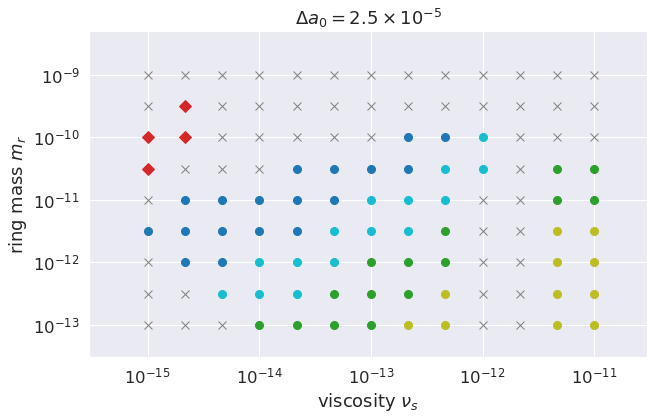

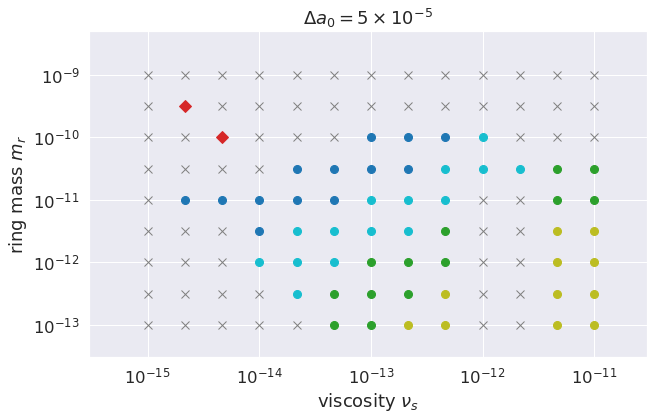

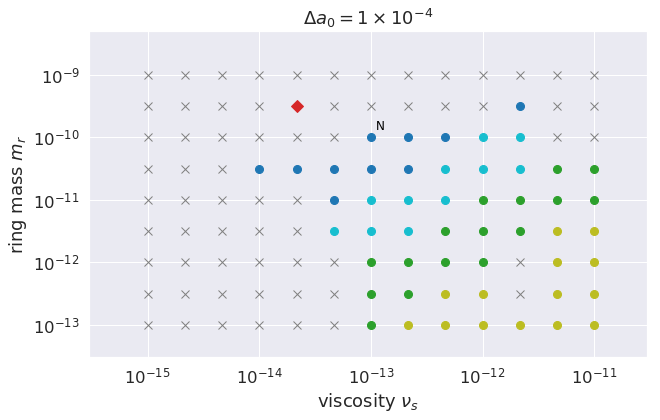

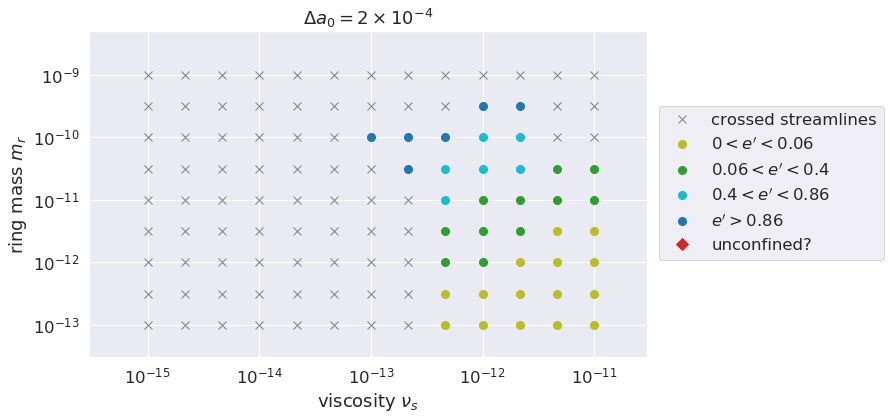

In [14]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.0, r"$0 < e'<0.06$", color_seq[8]),
                    (0.06, r"$0.06<e'<0.4$", color_seq[2]),
                    (0.4, r"$0.4<e'<0.86$", color_seq[9]),
                    (0.86, r"$e'>0.86$", color_seq[0])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #diamond for simulation complete sims
    idx = (dfs.outcome == 'unconfined')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    color = color_seq[3]
    p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unconfined?')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (1.1*xp, 1.3*yp)
        color = color_seq[3]
        p = ax.annotate('N', xy, fontsize=12, color='black')
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    if (radial_width == 2.5e-5):
        title = r'$\Delta a_0 = 2.5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p000025.pdf'
    if (radial_width == 5.0e-5):
        title = r'$\Delta a_0 = 5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p00005.pdf'
    if (radial_width == 1.0e-4):
        title = r'$\Delta a_0 = 1\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0001.pdf'
    if (radial_width == 2.0e-4):
        title = r'$\Delta a_0 = 2\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0002.pdf'
    p = ax.set_title(title)
    p = ax.set_xlim(3.0e-16, 3.0e-11)
    p = ax.set_ylim(3.0e-14, 5.0e-9)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    print 'file = ', file, '    radial_width = ', radial_width
    plt.savefig(file, bbox_inches='tight')

In [15]:
#conda install scikit-learn
#conda install pyarrow

number of e_prime_bracket=0.86 sims =  47
number of sims plotted =  5


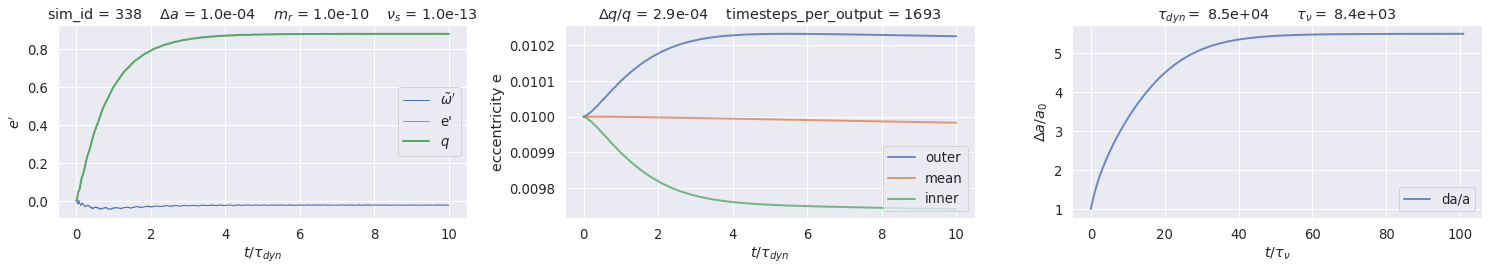

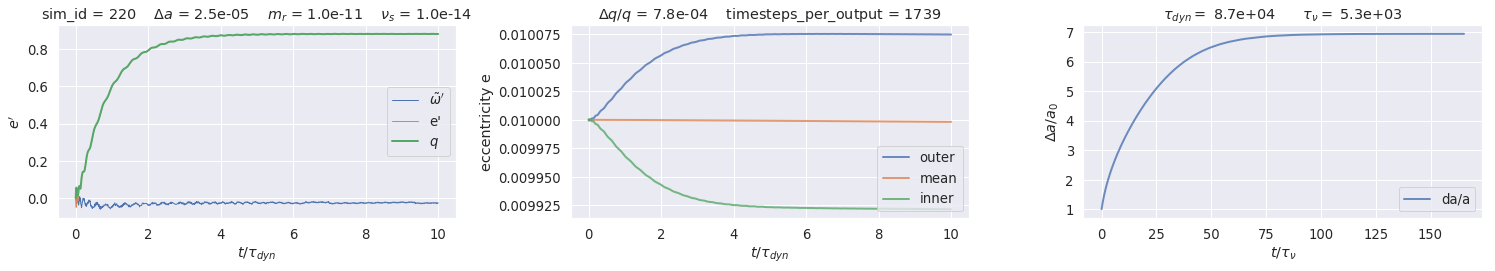

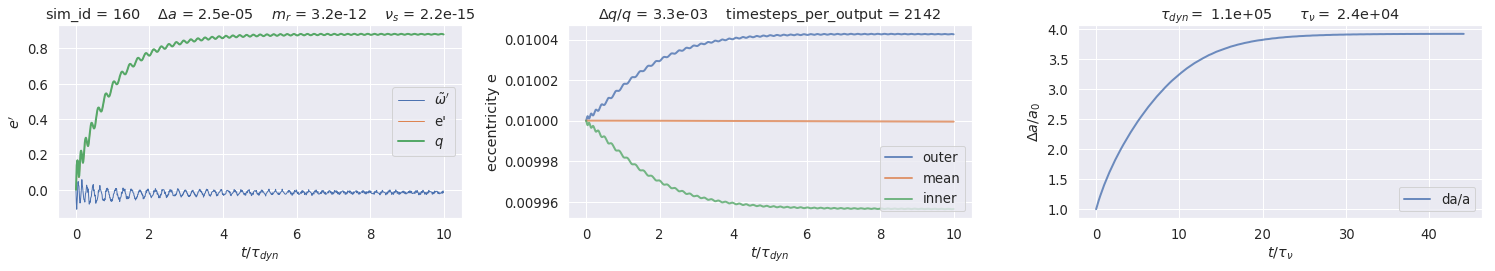

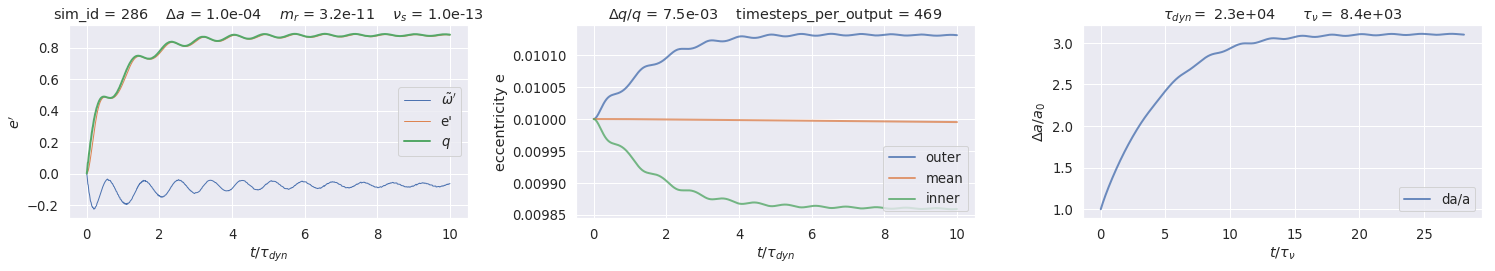

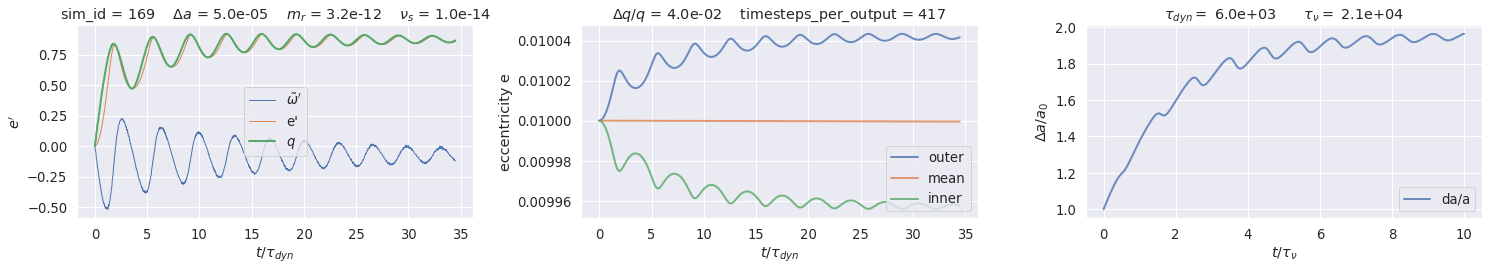

In [16]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.86
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.86 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.4 sims =  47
number of sims plotted =  5


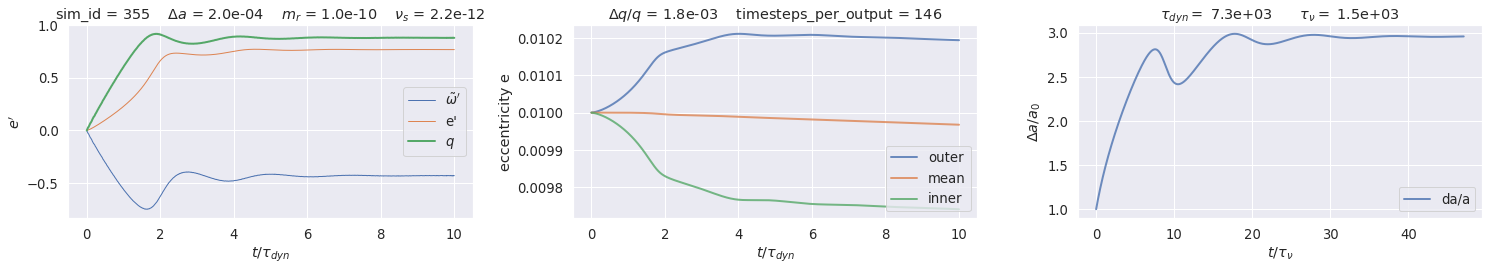

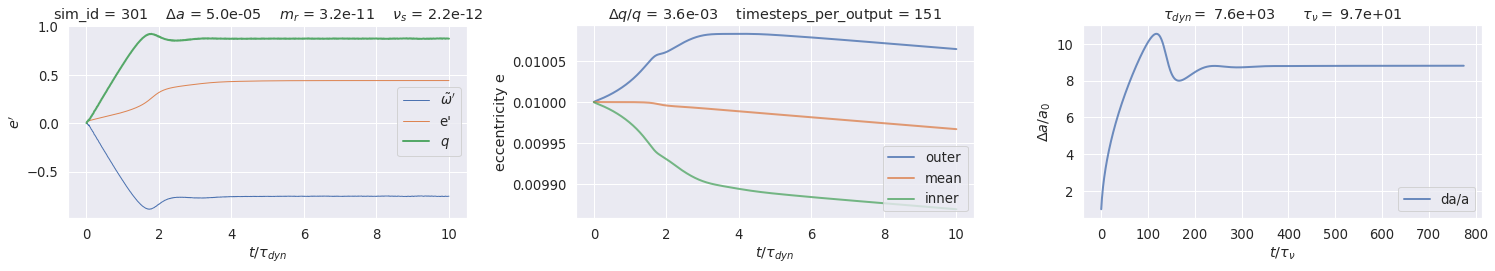

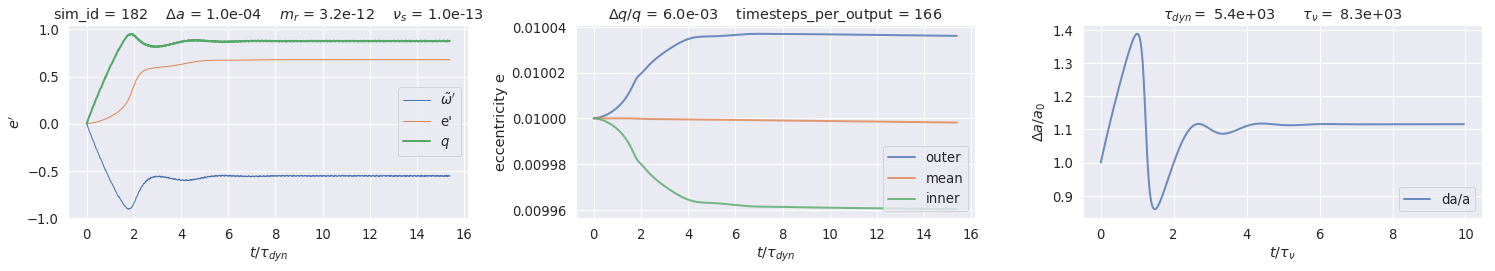

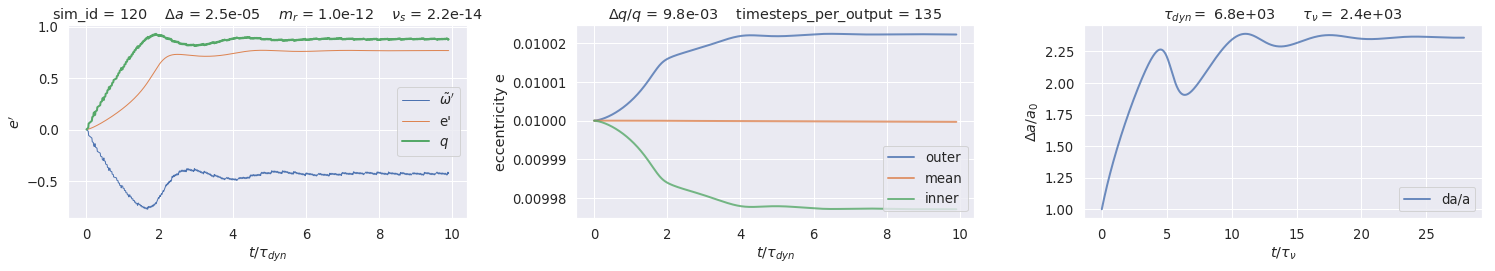

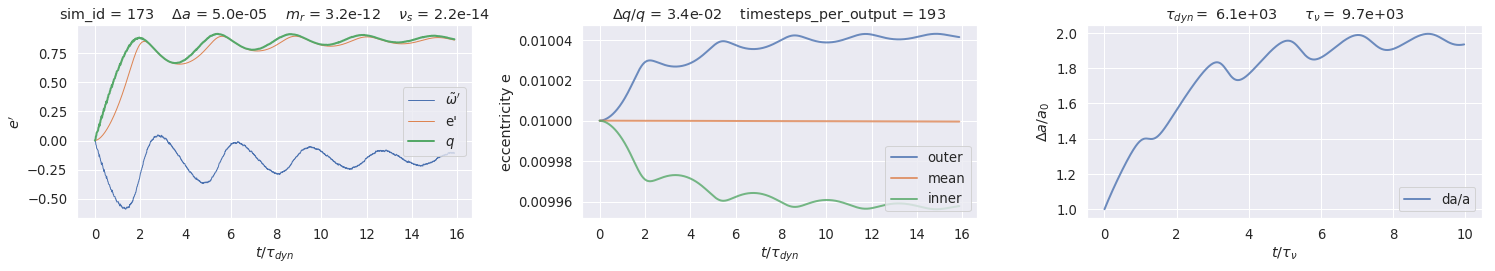

In [17]:
#generate summary plots for sample of e_prime_bracket=0.4 (ie 0.4<e'<0.86) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.4
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.4 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.06 sims =  55
number of sims plotted =  5


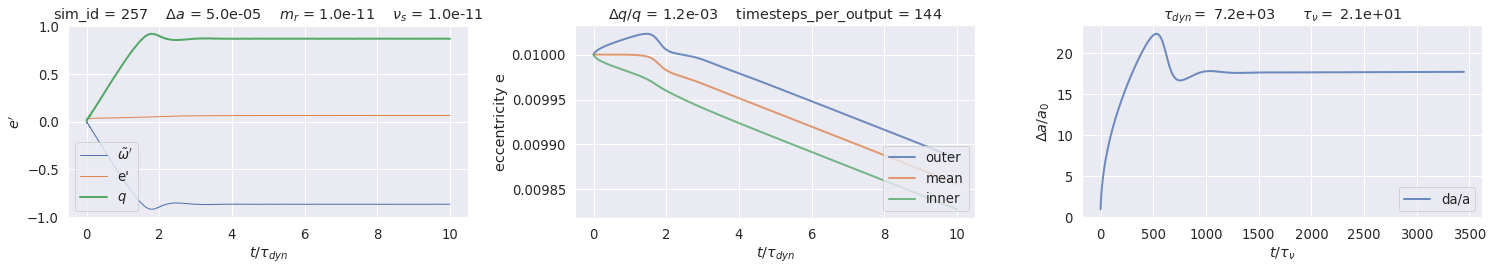

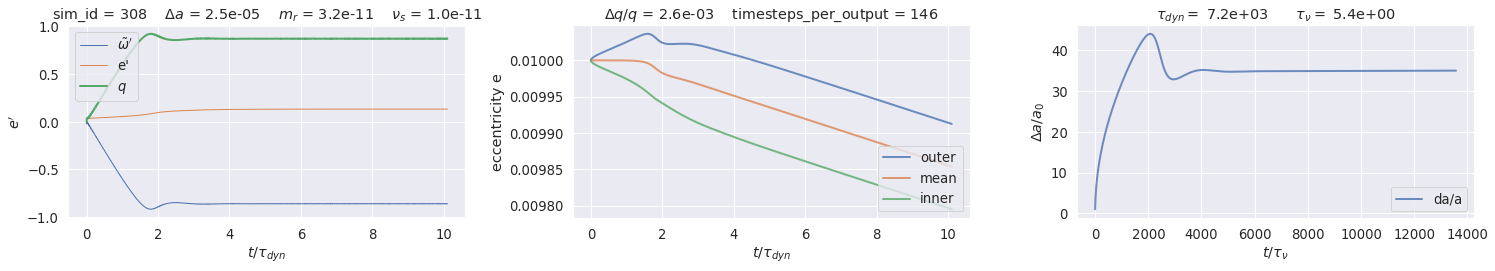

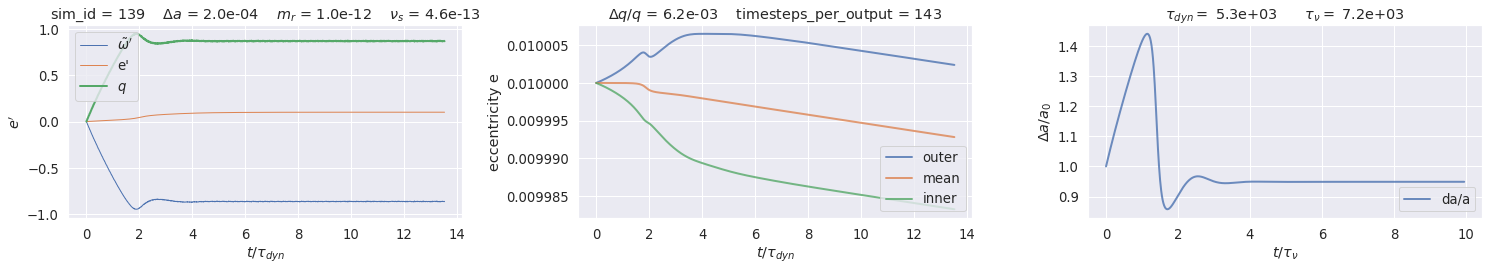

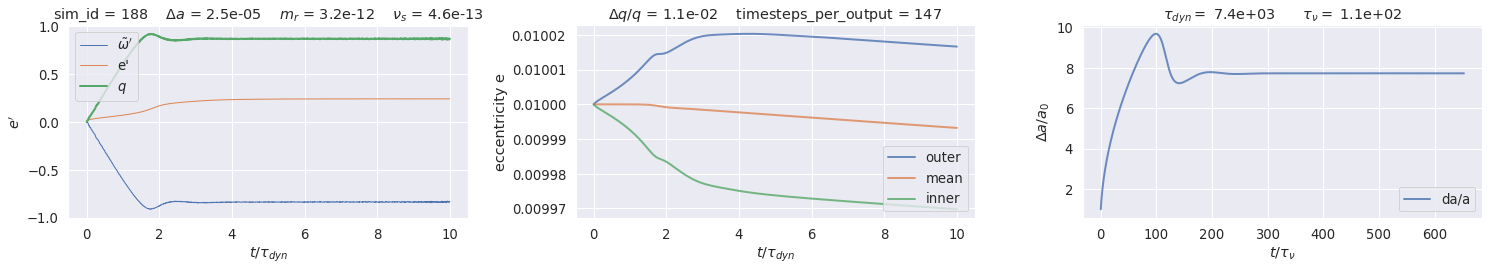

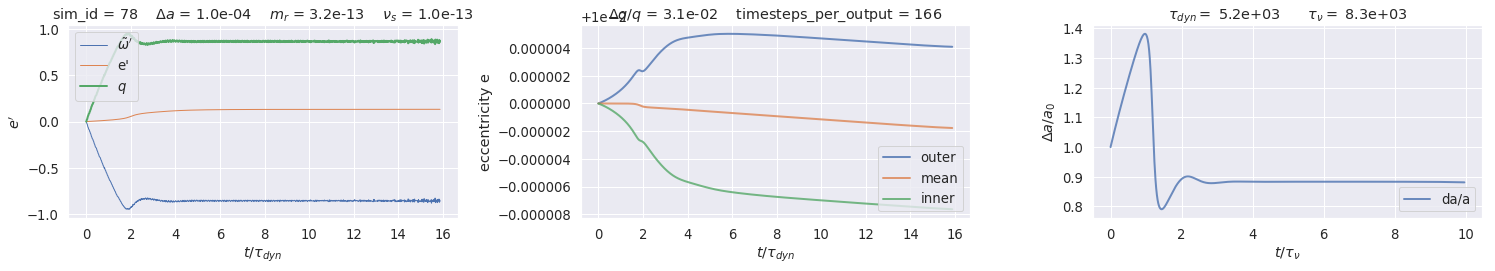

In [18]:
#generate summary plots for sample of e_prime_bracket=0.06 (ie 0.06<e'<0.4) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.06
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.06 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  51
number of sims plotted =  5


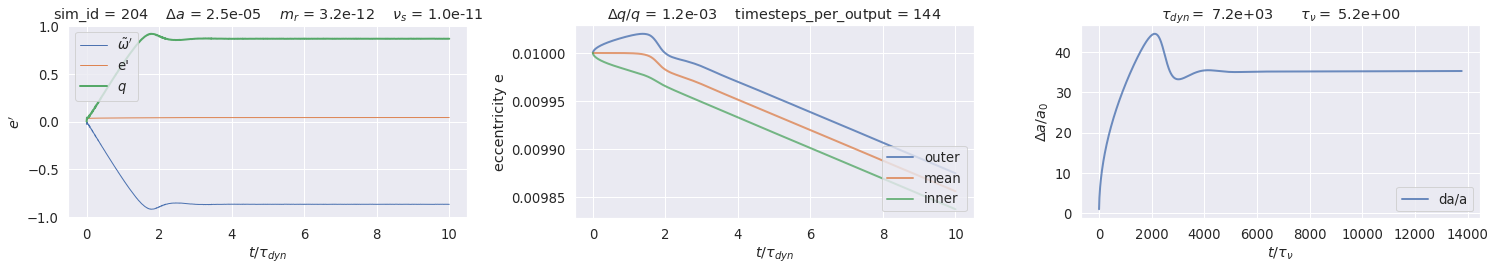

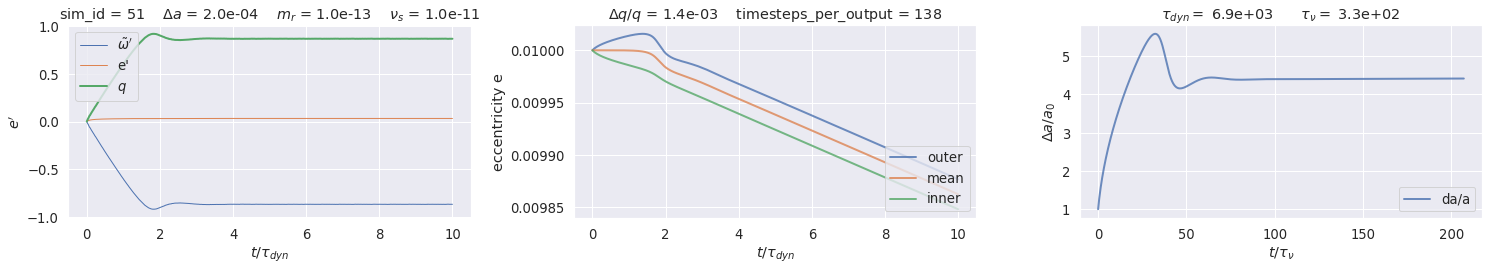

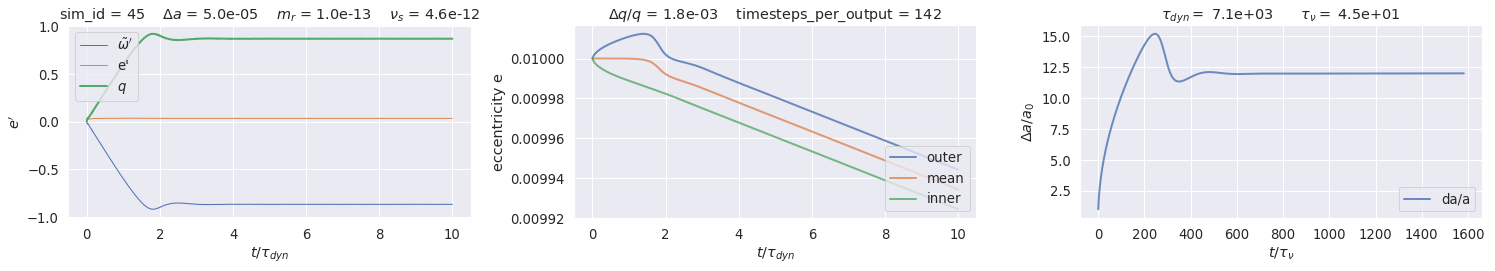

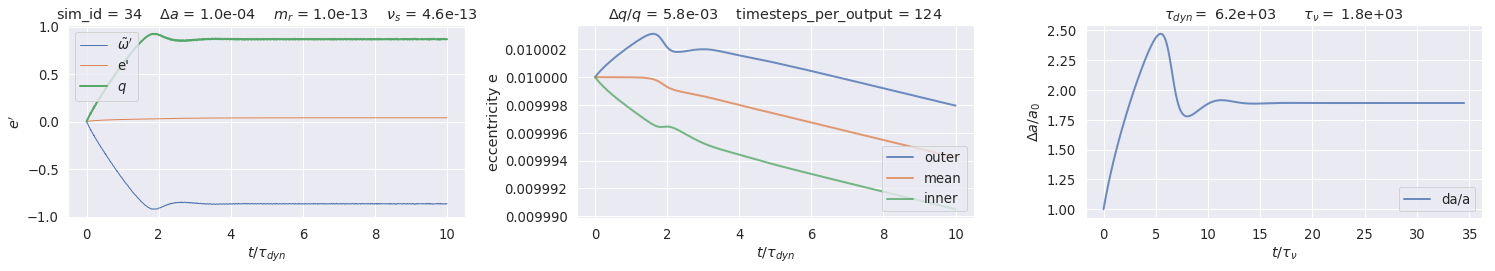

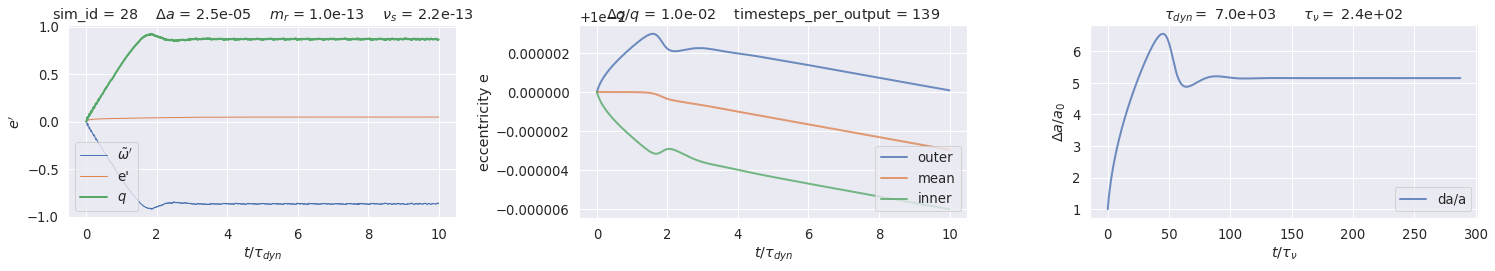

In [19]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.06) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of unconfined sims =  7
number of sims plotted =  7


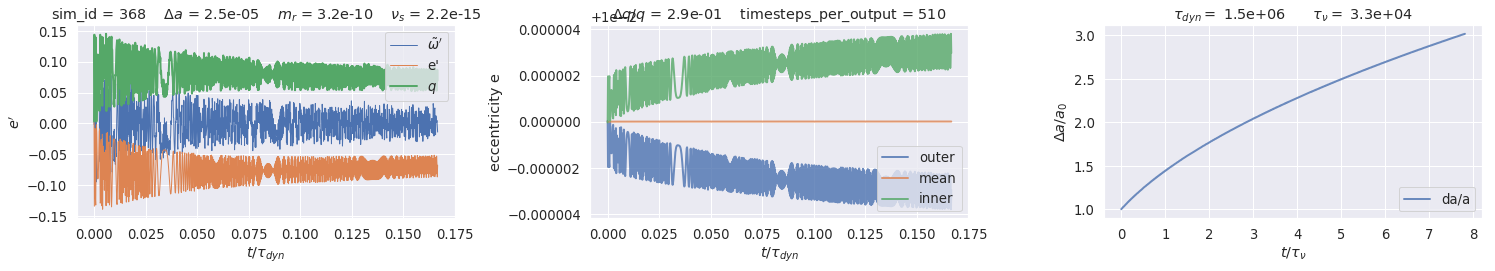

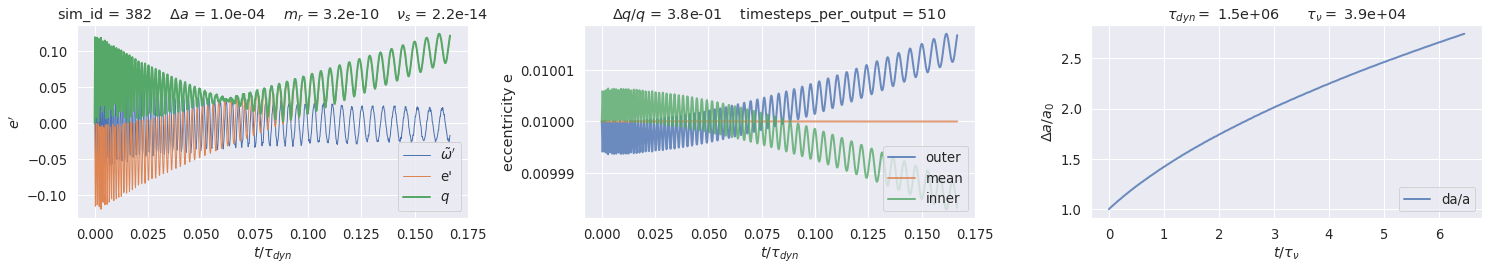

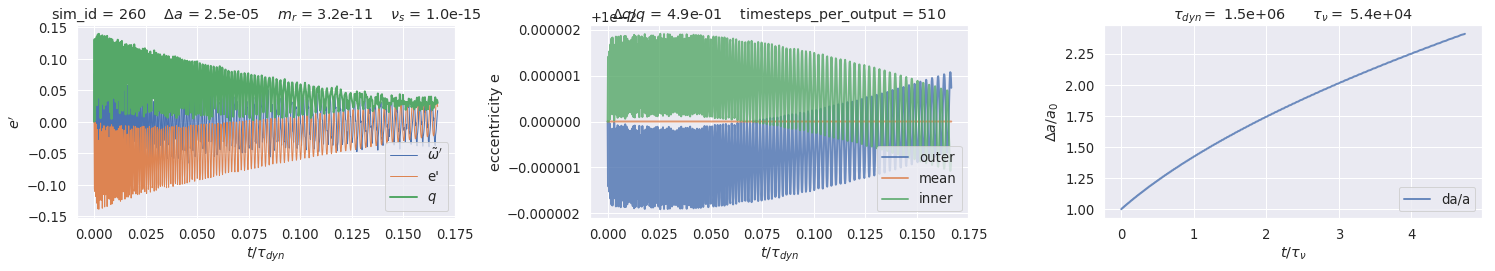

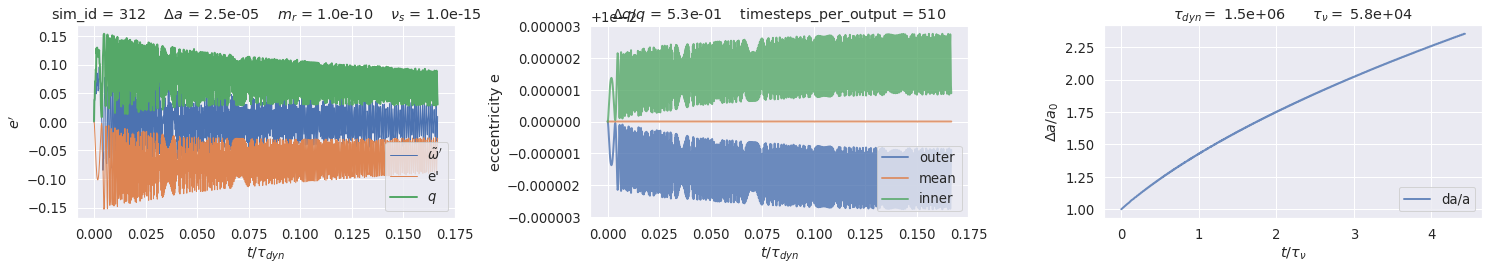

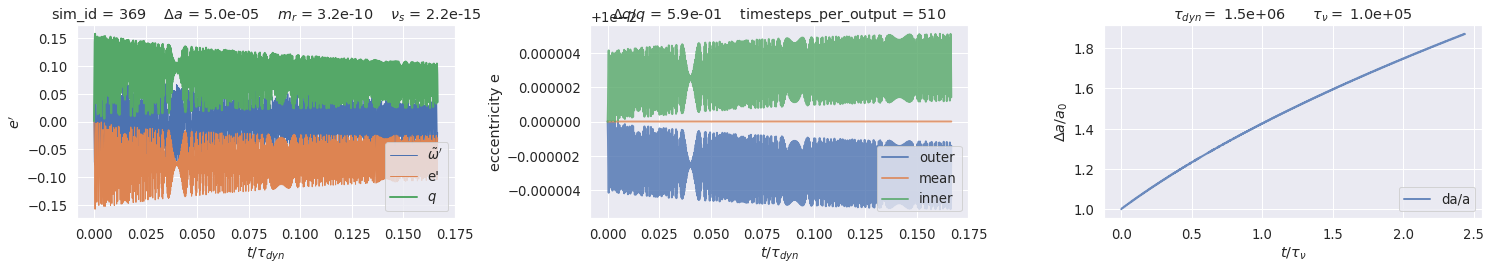

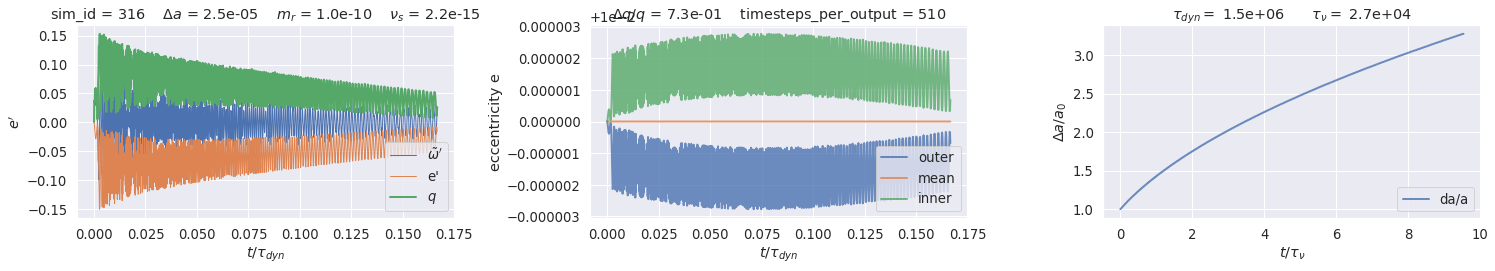

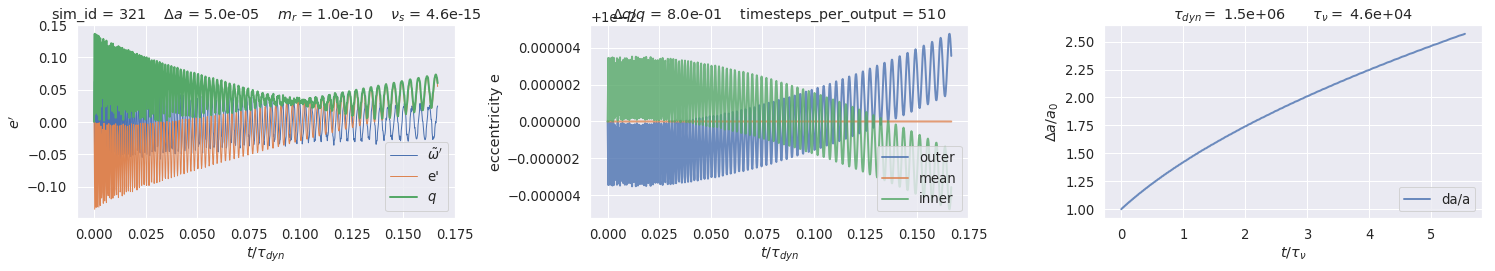

In [20]:
#generate summary plots for all unconfined sims sorted by delta_q_over_q
df = df_results
N_plots = 7
xlim = (-1, 11)
idx = (df.outcome == 'unconfined')
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of unconfined sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
#idx = ((df.sim_id == 315) | (df.sim_id == 319) | (df.sim_id == 443) | (df.sim_id == 444))
#dfss = df[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of sims plotted =  10


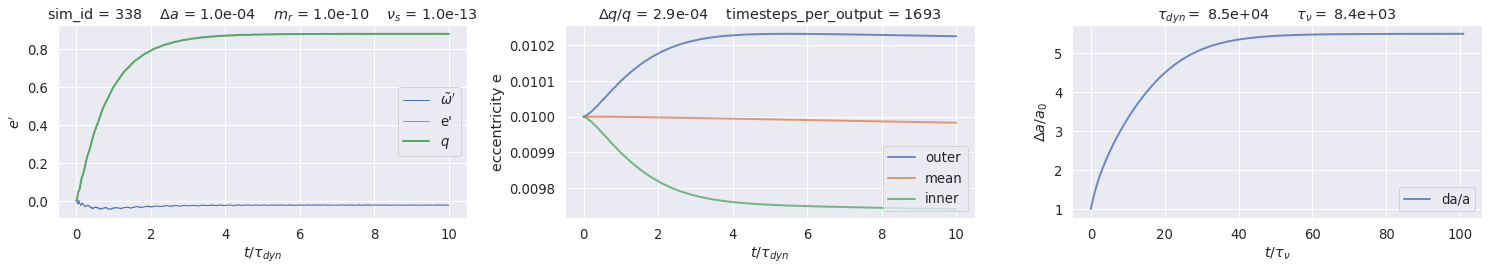

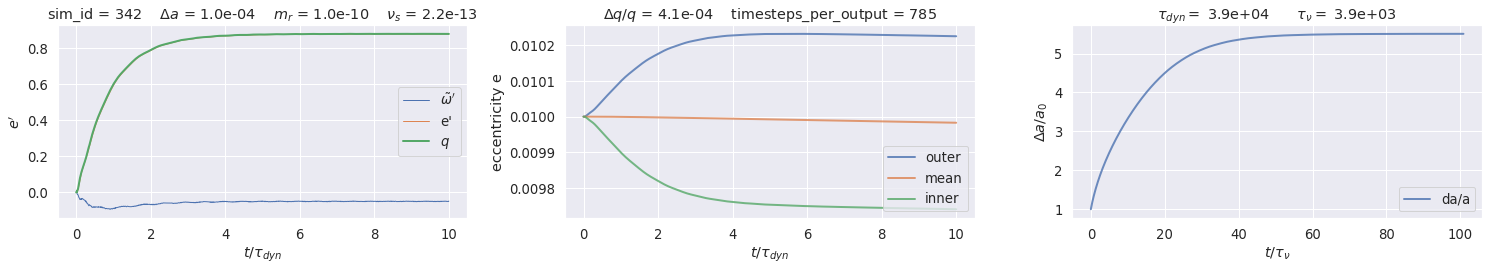

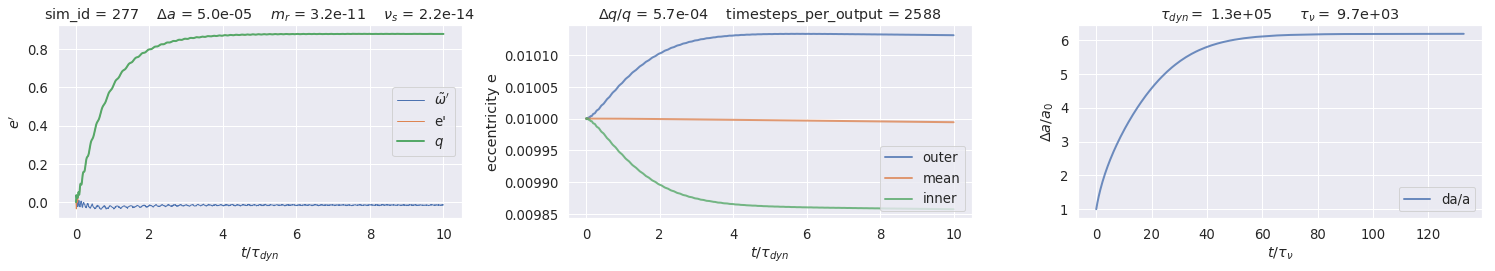

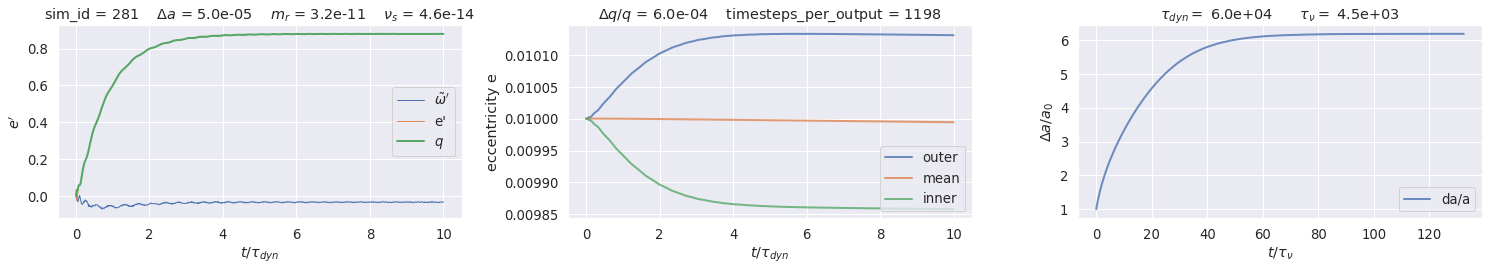

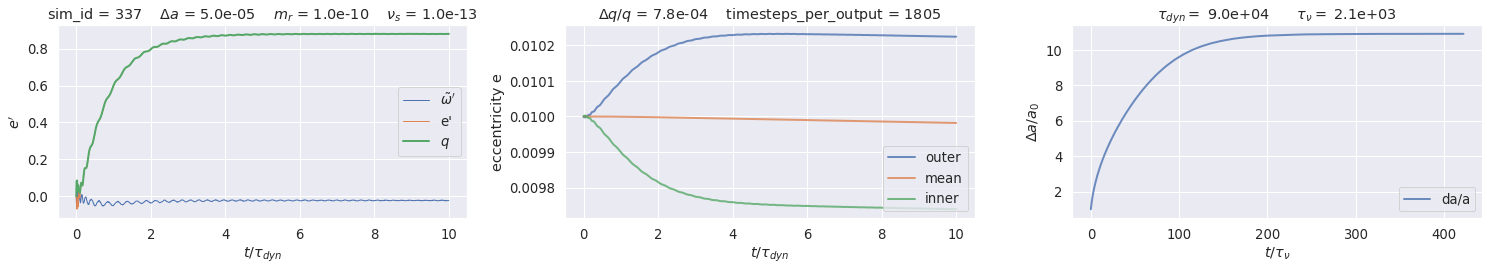

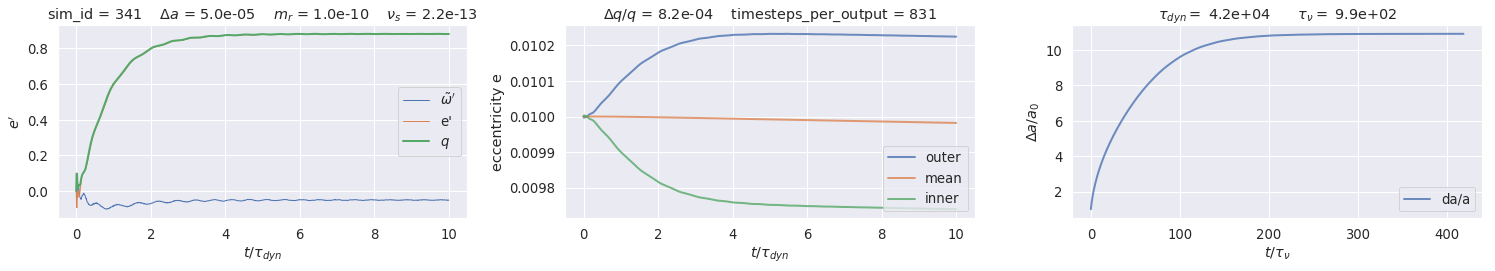

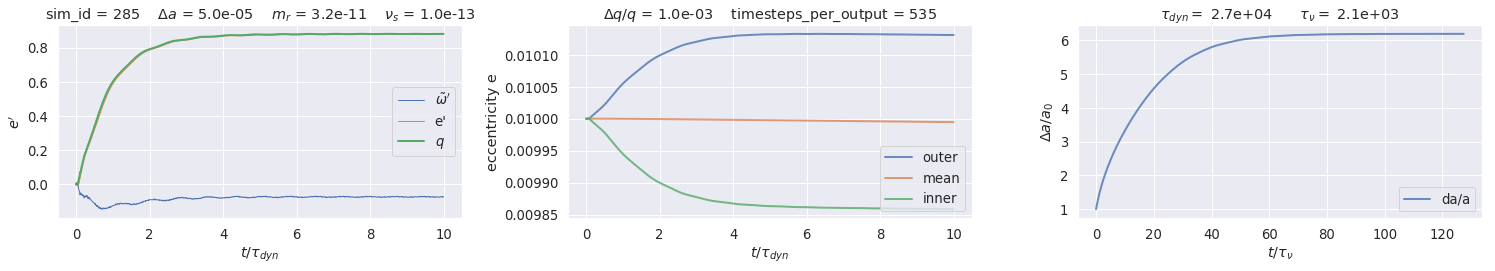

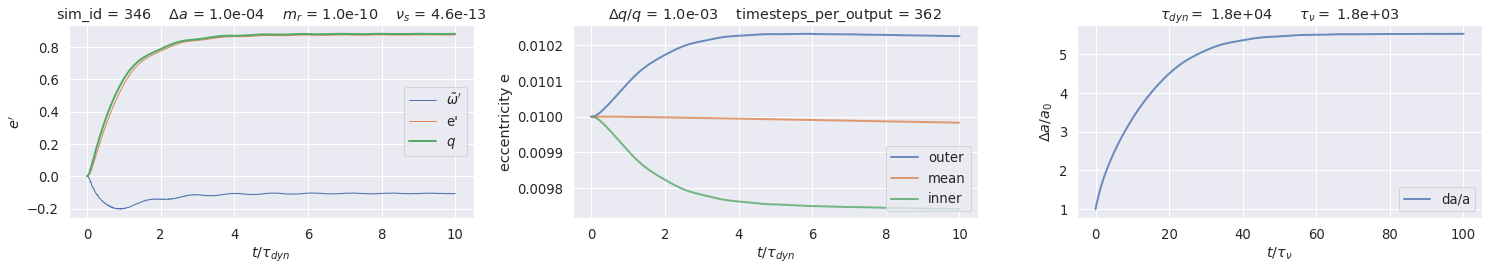

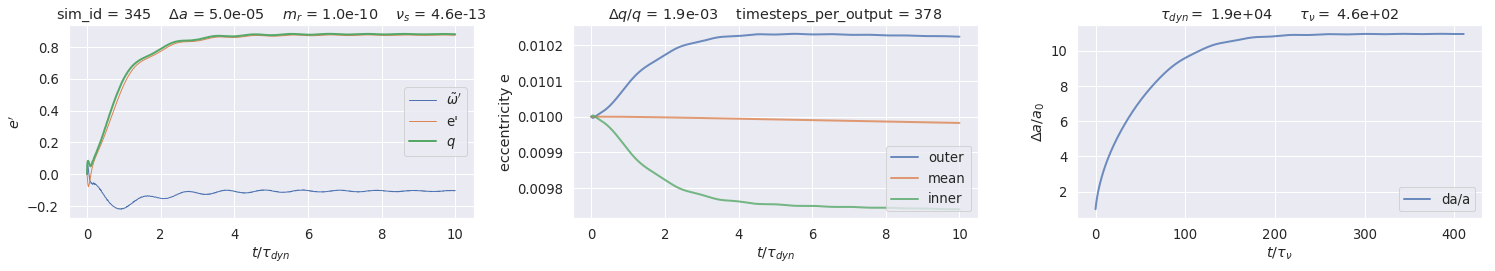

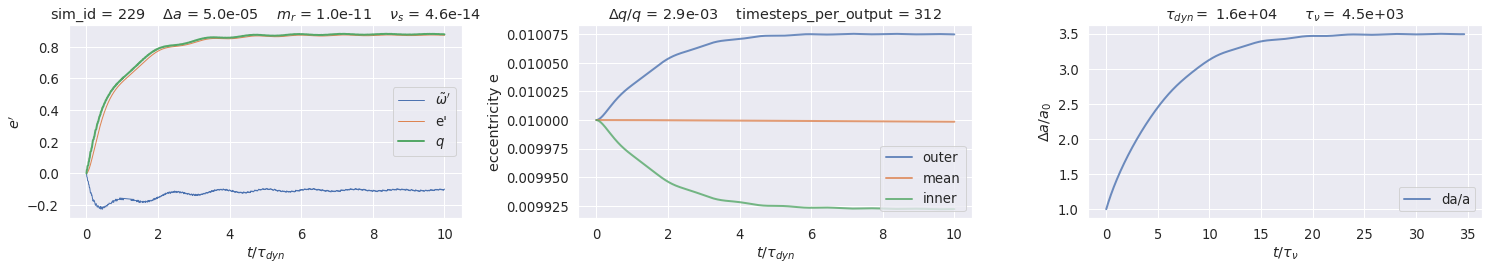

In [21]:
#find most nominal sim
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'self-confining')
dfs = df[idx].copy()
idx = (dfs.radial_width > 3.0e-5) & (dfs.radial_width < 1.5e-4) & (dfs.e_prime_bracket > 0.7) \
    & (dfs.delta_q_over_q < 0.003)
dfss = dfs[idx]
dfss = dfss.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()


In [22]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min

time_exec_min =  1.24672710101
